# Machine Learning - An introduction to scikit-learn with GTEX data<br>
Scikit learn is built upon Scientific Python stack:
* **NumPy**: Base n-dimensional array package
* **SciPy**: Fundamental library for scientific computing
* **Matplotlib**: Comprehensive 2D/3D plotting
* **IPython**: Enhanced interactive console
* **Sympy**: Symbolic mathematics
* **Pandas**: Data structures and analysis

In [1]:
# Import necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# allow plotting in the jupyter notebook
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


# GTEX <br>
A super valuable gene expression resource cataloging 53 tissues across 714 donors. <br>
Check it out: https://www.gtexportal.org/home/

BISB's very own Brian Tsui works with GTEX data often, so he gave me some pre-processed data for us to work with. <br>
This small dataset includes expression for 200 genes across 5 different tissues.

In [2]:
df = pd.read_csv('./data/gtex_data.csv', index_col=0).transpose()
annot = pd.read_csv('./data/gtex_annotations.csv', index_col=0)

In [3]:
df.shape

(757, 200)

Transform the gene expression to logarithmic space to make it easier to work with.

In [4]:
def get_log(x):
    if x == 0:
        return 0
    else:
        return np.log(x)
     
for col in df.columns:
    df.loc[:, col] = df.loc[:, col].apply(get_log)

A useful function to map annotations with sample names. We'll be using this later.

In [5]:
def get_location(x):
    try:
        return list(annot[annot.Run == x].Body_Site)[0]
    except:
        return ''

### Before we jump into machine learning, let's take a look at the data

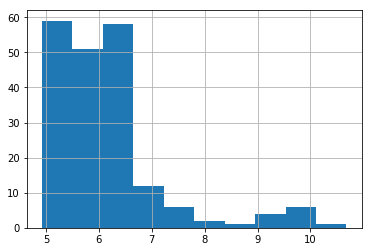

In [6]:
# The distribution of average gene expression per gene
df.mean().hist()

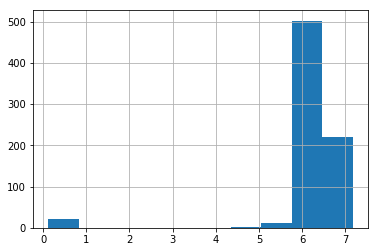

In [7]:
# The distribution of average gene expression per patient
df.mean(axis=1).hist()

The plot above shows that some of the samples are major outliers without any expression. Let's remove those. 

In [8]:
# drop the outliers
df = df[df.mean(axis=1) > 4]

The number of samples from each tissue type

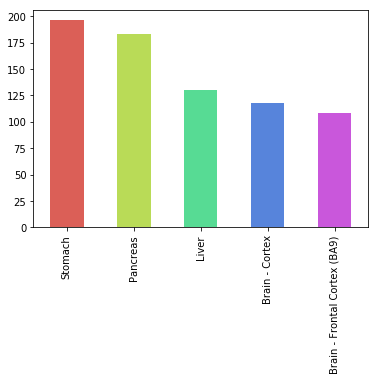

In [9]:
annot.index = annot.Run
annot.loc[df.index].Body_Site.value_counts().plot(kind='bar', 
                                                  color=sns.color_palette("hls", len(annot.Body_Site.unique())))

# Unsupervised learning <br>
These are the kinds of problems where you want to learn something about the data without using (or even knowning) the "labels".

For this tutorial, we are going to explore and visualize how the gene expression profiles of the patients relate to each other

## Dimensionality Reduction

This is the idea of going from many dimensions (in our case, 200 genes) and reducing it to a visualizable number (2, here)

### PCA

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA(n_components=4)
pca.fit(df)
pcs = pca.transform(df)

In [12]:
pca_df = pd.DataFrame(pcs)
pca_df.columns = ['pc1', 'pc2', 'pc3', 'pc4']
pca_df['sample'] = df.index

In [13]:
pca.explained_variance_ratio_

array([0.39507683, 0.23205593, 0.09315826, 0.0588585 ])

In [14]:
pca_df['site'] = pca_df['sample'].apply(get_location)

In [15]:
palette = sns.color_palette("hls", len(annot.Body_Site.unique()))
colors = {}
for i, site in enumerate(annot.Body_Site.unique()):
    colors[site] = palette[i]
pca_df['color'] = pca_df.site.map(colors)

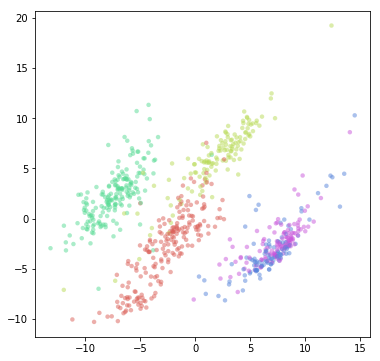

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(pca_df.pc1, pca_df.pc2, c=pca_df.color, lw = 0, alpha=0.5, s=20)

### t-SNE

In [17]:
from sklearn.manifold import TSNE

In [18]:
model = TSNE(n_components=2, random_state=0)
TSNEs = model.fit_transform(df)

In [19]:
tsne_df = pd.DataFrame(TSNEs)
tsne_df.columns = ['tsne1', 'tsne2']
tsne_df['sample'] = df.index

In [20]:
tsne_df['population'] = tsne_df['sample'].apply(get_location)
palette = sns.color_palette("hls", len(annot.Body_Site.unique()))
colors = {}
for i, population in enumerate(annot.Body_Site.unique()):
    colors[population] = palette[i]
tsne_df['color'] = tsne_df.population.map(colors)

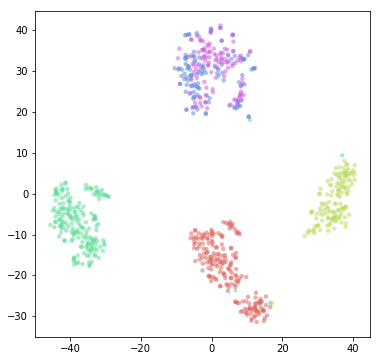

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(tsne_df.tsne1, tsne_df.tsne2, c=tsne_df.color, lw = 0, alpha=0.5, s=20)

## Clustering <br>

Clustering methods use all of the data to group patients with the most featurs (or similar gene expression profiles)

### Hierarchical clustering 

In [22]:
colors

{'Brain - Cortex': (0.7871999999999999, 0.33999999999999997, 0.86),
 'Brain - Frontal Cortex (BA9)': (0.33999999999999997,
  0.5167999999999995,
  0.86),
 'Liver': (0.7247999999999999, 0.86, 0.33999999999999997),
 'Pancreas': (0.33999999999999997, 0.86, 0.5792000000000002),
 'Stomach': (0.86, 0.3712, 0.33999999999999997)}

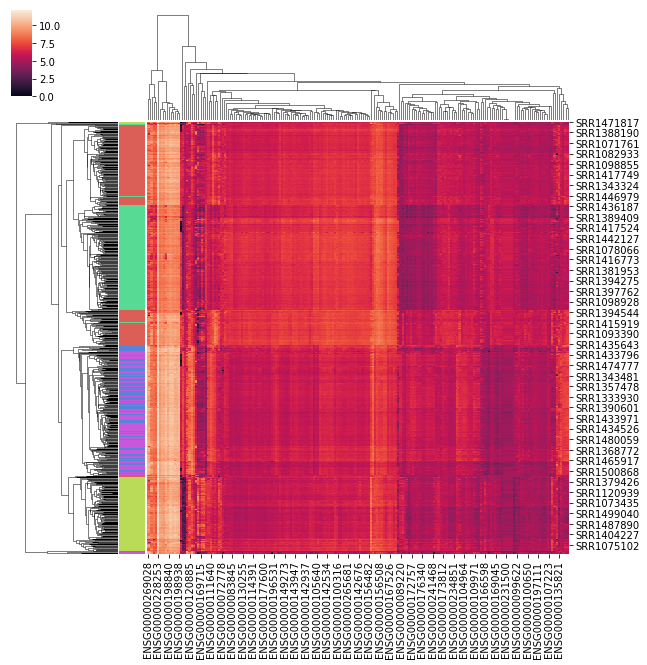

In [23]:
row_colors = [colors[list(annot[annot.Run == x].Body_Site)[0]] for x in df.index]

sns.clustermap(df, vmin=0, row_colors=row_colors)

# Supervised learning <br>
For these problems, you use the "label" to learn train an algorithm to predict the label on new data.

## Regression <br>

Regression methods use the features to try to discern a continuous value output. <br>
In our case, we are going to try to predict the gene expression of a single gene from all of the other genes.

Split into training set and test set

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Simple linear regression

In [27]:
from sklearn import linear_model

In [28]:
lr = linear_model.LinearRegression()

In [29]:
lr.fit(X_train, y_train)
y_predicted = lr.predict(X_test)

Assess error

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
mean_squared_error(y_test, y_predicted)

0.027650381395791977

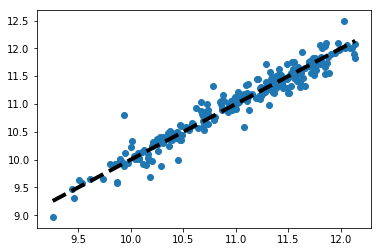

In [32]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

### Elastic Net <br>
Elastic net employs two regularization techniques to avoid overfitting

In [33]:
from sklearn.linear_model import ElasticNet

In [34]:
clf = linear_model.ElasticNet(alpha=0.1)

In [35]:
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

Assess error

In [36]:
mean_squared_error(y_test, y_predicted)

0.044113662035934025

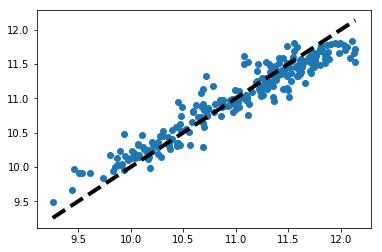

In [37]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

## Classification <br>
Classification methods use all of the features and try to classify the sample into a specific group. <br>
In our case, we will be trying to classify samples into their tissue group with the gene expression data.

In [38]:
from sklearn import preprocessing

In [39]:
X = df.values
y = annot.loc[df.index].Body_Site.values

In [40]:
le = preprocessing.LabelEncoder()

y = le.fit_transform(y)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:
y_test[:10]

array([4, 2, 2, 1, 1, 3, 2, 1, 4, 0])

#### Nearest Neighbor <br>
This is one of the simpliest classification techniques. It takes one or a couple of the most similar samples and classifies each new sample with the label of those closest ones.

In [43]:
from sklearn import neighbors

In [44]:
clf = neighbors.KNeighborsClassifier(3, weights='distance')
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

In [45]:
y_predicted = clf.predict(X_test)

Assess performance

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [47]:
accuracy_score(y_test, y_predicted)

0.9094650205761317

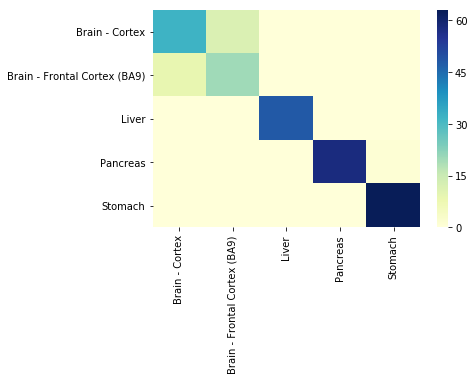

In [48]:
sns.heatmap(confusion_matrix(y_test, y_predicted), xticklabels=le.classes_, yticklabels=le.classes_,
           cmap="YlGnBu")

#### Decision Tree <br>

In [49]:
from sklearn.tree import DecisionTreeClassifier

In [50]:
clf = DecisionTreeClassifier(random_state=0)

In [51]:
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

Assess performance

In [52]:
accuracy_score(y_test, y_predicted)

0.8724279835390947

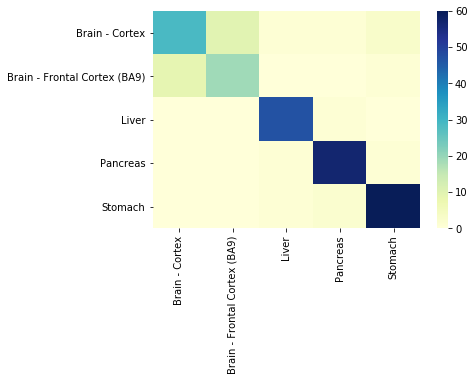

In [53]:
sns.heatmap(confusion_matrix(y_test, y_predicted), xticklabels=le.classes_, yticklabels=le.classes_,
           cmap="YlGnBu")

### Ensemble methods <br>
#### Random forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

In [56]:
y_predicted[:10]

array([4, 2, 2, 1, 1, 3, 2, 1, 4, 0])

Assess performance

In [57]:
accuracy_score(y_test, y_predicted)

0.9300411522633745

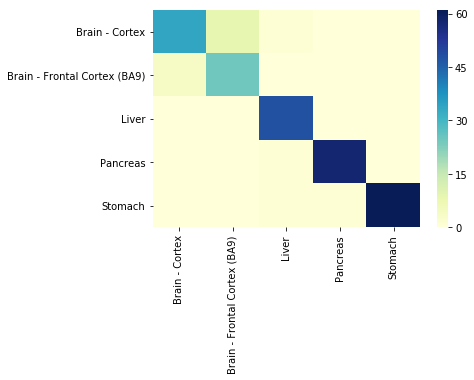

In [58]:
sns.heatmap(confusion_matrix(y_test, y_predicted), xticklabels=le.classes_, yticklabels=le.classes_,
           cmap="YlGnBu")